# Funnel Analysis

This exercise performs funnel analysis for an e-commerce website using hypothetical data.

The goal of this challange are the following:

* The CEO is not very happy with volume of sales, especially coming from new users. Therefore she asked you to investigate if there is something wrong in the conversion funnel. 


* Specifically, she is interested in the following:
    * A full picture of funnel conversion rate for both desktop and mobile
    * Some insights on what the product team should focus on in order to improve conversion rate as well as any other aspect of the data that could help the product team improve
    
## Data Engineering

Let's start by importing necessary packages and uploading the dataset.

In [40]:
# import Python packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import tree
from scipy import stats

In [2]:
# import the dataset
user = pd.read_csv("user_table.csv")
home = pd.read_csv("home_page_table.csv")
search = pd.read_csv("search_page_table.csv")
payment = pd.read_csv("payment_page_table.csv")
payment_confirmation = pd.read_csv("payment_confirmation_table.csv")

In [3]:
payment_confirmation.head()

,user_id,page
0,123100,payment_confirmation_page
1,704999,payment_confirmation_page
2,407188,payment_confirmation_page
3,538348,payment_confirmation_page
4,841681,payment_confirmation_page


In [89]:
len(user["user_id"].unique())

90400

Ok, so we have 90400 total users, 45200 that went to search page, 6029 that went to payment page, and 452 that actualy bought the product. *The exercise statement states that the user_id's are all unique, but let's check this. Also, let's check if any users have impossible data (says visted payment page but did not visit search page, for example).*

But before looking further into the data, let's join all the tables into one table, with columns representing how far each user made in the funnel process. For example, we need a table for "home_page", "search_page", "payment_page", and "payment_confirmation" that are binary. 

To do this, we need to join all the tables via **user_id** key.

In [4]:
# outer join with user table all other tables by "user_id" key
dfs = [user, home, search, payment, payment_confirmation]
col = ['user_id']
funnel = pd.concat( [d.set_index(col) for d in dfs], axis=1 ).reset_index()
funnel.columns = ['user_id','date','device','sex','home_page','search_page',
                  'payment_page','payment_confirmation']
funnel = funnel.fillna(0)

In [5]:
funnel.head()

,user_id,date,device,sex,home_page,search_page,payment_page,payment_confirmation
0,17,2015-04-21,Desktop,Male,home_page,search_page,0,0
1,28,2015-04-29,Desktop,Male,home_page,0,0,0
2,37,2015-02-21,Mobile,Male,home_page,search_page,0,0
3,38,2015-03-23,Mobile,Female,home_page,search_page,payment_page,0
4,55,2015-02-01,Desktop,Male,home_page,0,0,0


Great, our dataset is complete. Now let's look into the dataset for more insight. Let's look at portion of **device** and **sex** in each group of users that reach the next stage in funnel.

In [6]:
# replace categorical values in home_page, search_page, payment_page, and payment_confirmation
# to numerical
funnel['home_page'].replace('home_page', 1, inplace=True)
funnel['search_page'].replace('search_page', 1, inplace=True)
funnel['payment_page'].replace('payment_page', 1, inplace=True)
funnel['payment_confirmation'].replace('payment_confirmation_page', 1, inplace=True)
funnel.head(10)

# change date column to datetime 
funnel['date'] = pd.to_datetime(funnel['date'],unit='D')

Now check to mak sure the dataset makes sense (check for impossible data).

In [115]:
invalid_payment_page = len(funnel[ (funnel["search_page"] == 0) & (funnel["payment_page"] == 1) ])
invalid_payment_confirm = len(funnel[ (funnel["payment_confirmation"]) & \
                                     ( (funnel["search_page"] == 0) | (funnel["payment_page"] == 0)) ] )

# outputs
print "Total number of users:", len(funnel)
print "Visted payment page but not search_page (should be 0):", invalid_payment_page
print "Visted payment confirmation page but not searchor payment page(should be 0):", invalid_payment_confirm

Total number of users: 90400
Visted payment page but not search_page (should be 0): 0
Visted payment confirmation page but not searchor payment page(should be 0): 0


Ok, so the dataset does not have any impossible points, and is what the exercise statement states.

## Data Exploration and Visualization

Let's take a quick look at the data and check some important assumptions. Things to check include: what fraction of users go through each part of the funnel process, how sex/device affects the funnel process, and if the CEO's assertions that newer users' lack of conversion is true. 

In [72]:
funnel.groupby('device').mean().reset_index()

,device,user_id,home_page,search_page,payment_page,payment_confirmation
0,Desktop,498484.582492,1.0,0.5,0.05,0.002492
1,Mobile,499158.394702,1.0,0.5,0.10,0.010000


In [116]:
funnel.groupby('device').count().reset_index()

,device,user_id,date,sex,home_page,search_page,payment_page,payment_confirmation
0,Desktop,60200,60200,60200,60200,60200,60200,60200
1,Mobile,30200,30200,30200,30200,30200,30200,30200


In [8]:
funnel.groupby('sex').mean().reset_index()

,sex,user_id,home_page,search_page,payment_page,payment_confirmation
0,Female,498423.518358,1.0,0.503073,0.068774,0.005347
1,Male,498994.270182,1.0,0.496944,0.064644,0.004655


We can already answer one of the CEO's questions here regarding difference between mobile and desktop users.

**Mobile users do much better than desktop users in getting to the payment page. And once there, mobile users are also more likely to convert than desktop users.** 

**There are almost twice as many desktop users as mobile users! This is a worrisome stat, as mobile users convert twice as much as deskop users. Also, most of future growth is likely to come from mobile users in the e-commernce industry.**

The data also shows that women are more likely to convert, although the differences are small. Is this difference statistically significant? We can check by doing a simple t-test. First, let's explore the data bit more and perform this t-test after completing the feature enigneering. 

What does the data look like based on time?

In [9]:
funnel.describe(include=[np.object])

,device,sex
count,90400,90400
unique,2,2
top,Desktop,Male
freq,60200,45325


In [10]:
funnel.describe(include=[np.number])

,user_id,home_page,search_page,payment_page,payment_confirmation
count,90400.000000,90400.0,90400.000000,90400.000000,90400.000000
mean,498709.683473,1.0,0.500000,0.066704,0.005000
std,289040.674085,0.0,0.500003,0.249509,0.070534
min,17.000000,1.0,0.000000,0.000000,0.000000
25%,247978.750000,1.0,0.000000,0.000000,0.000000
50%,498267.000000,1.0,0.500000,0.000000,0.000000
75%,749789.250000,1.0,1.000000,0.000000,0.000000
max,999979.000000,1.0,1.000000,1.000000,1.000000


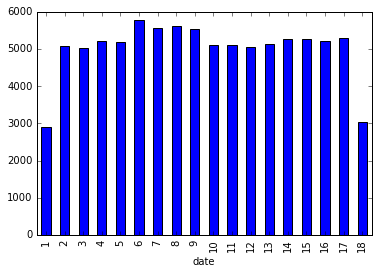

In [11]:
# plot histogram of dates
funnel['date'].groupby(funnel['date'].dt.week).count().plot(kind='bar')

So all the dates are in the year 2015, with same number of data points in each month from *January* to *April*. The sampling of days are even as well. Sampling of the week is fairly even except the 1st week (maybe due to New Years?) and the final week (week 18).

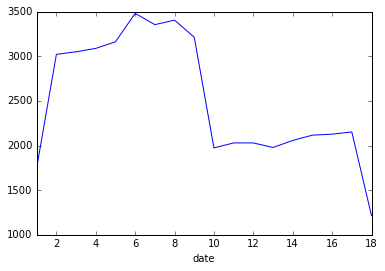

In [12]:
# number of users who went to search page
funnel['date'][funnel['search_page']==1].groupby(funnel['date'].dt.week).count().plot(kind='line')

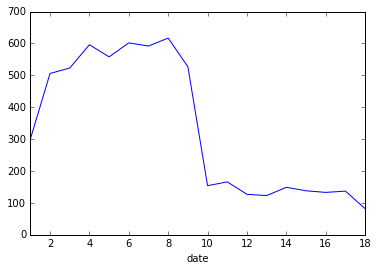

In [13]:
# number of users who went to payment page
funnel['date'][funnel['payment_page']==1].groupby(funnel['date'].dt.week).count().plot(kind='line')

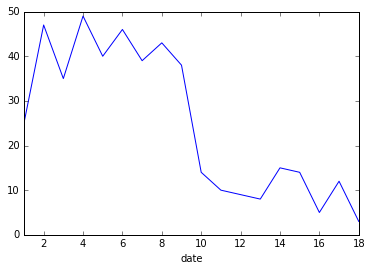

In [14]:
# number of users who went to payment confirmation page (fully converted)
funnel['date'][funnel['payment_confirmation']==1].groupby(funnel['date'].dt.week).count().plot(kind='line')

Ah, we see a drastic decrease in number of users going through the funnel pipeline past the home page starting week 10! That's the first week of March, which is what we see when we divide by month as well. It confirms what the CEO has told you, that conversion rate is low especially for new users.

Why this decrease in conversion rate? Perhaps the make up of the new users starting week 10 changed? Let's look at the how the portion of users change over time, especially if the portion of mobile/desktop users change.

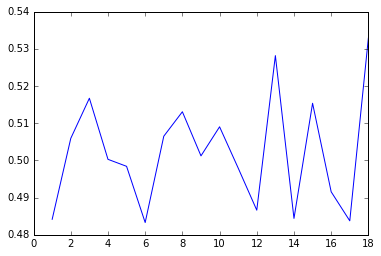

In [15]:
# device type ratio in data (mobile / desktop)
num_mobile = funnel['device'][funnel['device']=='Mobile'].groupby(funnel['date'].dt.week)\
.count()
num_desktop = funnel['device'][funnel['device']=='Desktop'].groupby(funnel['date'].dt.week)\
.count()
plt.plot(num_mobile/num_desktop)

Hmmm... ok so the ratio of desktop and mobile users in the data remains fairly constant over time. What about sex?

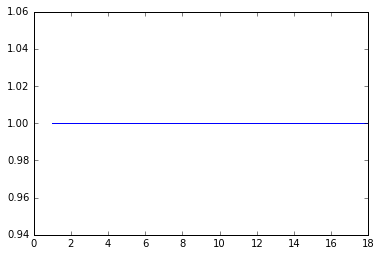

In [16]:
# sex ratio in the data
num_female = funnel['sex'][funnel['sex']=='Male'].groupby(funnel['date'].dt.week).count()
num_male = funnel['sex'][funnel['sex']=='Male'].groupby(funnel['date'].dt.week).count()
num_male = num_male.astype(float)
plt.plot(num_male/num_female)

Ratio of sex in the users data remained same as well. Then what is causing the drop in conversion through the funnel process?

Perhaps machine learning can give more information. Let's do some feature engineering to ready the dataset for machine learning algorithm.

First, convert all categorical data to numerical data. For date, change the date to one of the 18 weeks represented in the dataset. 

In [24]:
# convert categorical data into numerical for "device" and "sex"
data = pd.get_dummies(funnel, ["device", "sex"])

# convert date to week of the year
data['week'] = data['date'].dt.week

# drop "user_id" and "date" columns
data = data.drop(["user_id", "date"], axis=1)

In [25]:
data.head()

,home_page,search_page,payment_page,payment_confirmation,device_Desktop,device_Mobile,sex_Female,sex_Male,week
0,1,1,0,0,1.0,0.0,0.0,1.0,17
1,1,0,0,0,1.0,0.0,0.0,1.0,18
2,1,1,0,0,0.0,1.0,0.0,1.0,8
3,1,1,1,0,0.0,1.0,1.0,0.0,13
4,1,0,0,0,1.0,0.0,0.0,1.0,5


Great, the dataframe looks good and ready for the machine learning algorithm. Let's quickly perform the t-test on gender of the user and each group's conversion rate through the funnel pipeline.

Since the measurements here are categorical (conversion through each stage of the funnel) and taken from two distinct groups (Male and Female), the t-test involves comparing two independent proportions.

In [38]:
# perform 2 tailed independent t-test

# t-test on reaching the search page
male_search = data[data["sex_Male"] == 1][["sex_Male","search_page"]]
female_search = data[data["sex_Female"] == 1][["sex_Female","search_page"]]
print "SEARCH PAGE T-TEST: ", stats.ttest_ind(male_search["search_page"],
                                              female_search["search_page"])

# t-test on reaching the payment page
male_payment = data[data["sex_Male"] == 1][["sex_Male","payment_page"]]
female_payment = data[data["sex_Female"] == 1][["sex_Female","payment_page"]]
print "PAYMENT PAGE T-TEST: ", stats.ttest_ind(male_payment["payment_page"],
                                               female_payment["payment_page"])

# t-test on reaching the payment confirmation page
male_payment_con = data[data["sex_Male"] == 1][["sex_Male","payment_confirmation"]]
female_payment_con = data[data["sex_Female"] == 1][["sex_Female","payment_confirmation"]]
print "PAYMENT CONFIMRATION PAGE T-TEST: ", stats.ttest_ind(male_payment_con["payment_confirmation"],
                                                            female_payment_con["payment_confirmation"])

SEARCH PAGE T-TEST:  Ttest_indResult(statistic=-1.8425978559681095, pvalue=0.06539101967947282)
PAYMENT PAGE T-TEST:  Ttest_indResult(statistic=-2.4884647003000326, pvalue=0.012831383209203481)
PAYMENT CONFIMRATION PAGE T-TEST:  Ttest_indResult(statistic=-1.473571917457817, pvalue=0.14060036909365287)


*The p-value for all three tests are above the typical cutoff of 0.05, which means we accept the null hypothesis that the results of conversion through the funnel between men and women are not statistically significant.* 

## Machine Learning

To understand in more detail which features are most important in predicting whether or not a user goes through each stage of the funnel process, we feed the dataset to a **decision tree** model. 

Note, that the decision tree is simply being used here to better visualize what are the important features that affect the conversion rate. It is *NOT* being used here as a general model to predict conversion for some future user, but simply to gain more insight about the data.


In [67]:
# create X and Y dataset
x = data[["device_Desktop","device_Mobile","week","sex_Female","sex_Male"]]
y_search = data["search_page"]
y_payment = data["payment_page"]
y_payment_conf = data["payment_confirmation"]

In [68]:
# fit the tree model (max depth of 2 and min leaf samples of 1% of dataset)
clf = tree.DecisionTreeClassifier(max_depth=2, min_samples_leaf=len(data)/100)
search_tree = clf.fit(x, y_search)
payment_tree = clf.fit(x, y_payment)
payment_conf_tree = clf.fit(x, y_payment_conf)

In [69]:
# check the model results
print x.columns[search_tree.tree_.feature]
print search_tree.tree_.threshold

print x.columns[payment_tree.tree_.feature]
print payment_tree.tree_.threshold

print x.columns[payment_conf_tree.tree_.feature]
print payment_conf_tree.tree_.threshold

Index([u'device_Desktop', u'week', u'sex_Female', u'sex_Female', u'week',
       u'sex_Female', u'sex_Female'],
      dtype='object')
[ 0.5  9.5 -2.  -2.   9.5 -2.  -2. ]
Index([u'device_Desktop', u'week', u'sex_Female', u'sex_Female', u'week',
       u'sex_Female', u'sex_Female'],
      dtype='object')
[ 0.5  9.5 -2.  -2.   9.5 -2.  -2. ]
Index([u'device_Desktop', u'week', u'sex_Female', u'sex_Female', u'week',
       u'sex_Female', u'sex_Female'],
      dtype='object')
[ 0.5  9.5 -2.  -2.   9.5 -2.  -2. ]


In [70]:
# visualize the tree
searchfile = open("search.dot",'w')
tree.export_graphviz(search_tree, out_file = searchfile, feature_names=x.columns)
searchfile.close()

paymentfile = open("payment.dot",'w')
tree.export_graphviz(payment_tree, out_file = paymentfile, feature_names=x.columns)
paymentfile.close()

paymentconffile = open("paymentconf.dot",'w')
tree.export_graphviz(payment_conf_tree, out_file = paymentconffile, feature_names=x.columns)
paymentconffile.close()

The decision tree confirms what we alread know from the initial exploration of the data. The drop in sales is likely a seasonal issue or something that the company did (change the website layout, finished sales... etc) starting the 10th week of the year.

## Conclusion

Ok, with the completed analysis, we can answer the CEO's questions.

* The CEO is not very happy with volume of sales, especially coming from new users. Therefore she asked you to investigate if there is something wrong in the conversion funnel. 

**The conversion rate from the payment page to the payment confirmation page is only about 10%. This is likely an area that the company can improve in the funnel process.**

**There is a large drop in conversion rate through the entire funnel process for all users (different sex and devices) at week 10 by a factor of 2-3. The fact that the composition of users throughout the sampled weeks did not change (equal ratio of sexes and device types) suggets a more fundamental reason for the sales drop, perhaps a seasonal effect or something company-wide.**

* Specifically, she is interested in the following: A full picture of funnel conversion rate for both desktop and mobile.
    
**The conversion from search page to payment page and payment confirmation page is twice as high for mobile users as is for desktop users. The desktop funnel process starting from the search page should be improved to increase conversion rate for desktop users.**     

**The userbase consists of 2:1 favoring desktop users. This is not in line with rest of the industry and future growth, both of which heavily favors mobile users. The mobile product needs significant attention to draw more users.**
    
* Some insights on what the product team should focus on in order to improve conversion rate as well as any other aspect of the data that could help the product team improve.
    
**The product team should focus on improving the funnel process for desktop users. Also, more focus should be given to the payment page, as 9/10 users drop out here and do not complete the payment process.**

In [83]:
funnel_device = funnel.groupby('device').mean().reset_index()
print funnel_device
print funnel_device["payment_page"] / funnel_device["search_page"]
print funnel_device["payment_confirmation"] / funnel_device["payment_page"]

    device        user_id  home_page  search_page  payment_page  \
0  Desktop  498484.582492        1.0          0.5          0.05   
1   Mobile  499158.394702        1.0          0.5          0.10   

   payment_confirmation  
0              0.002492  
1              0.010000  
0    0.1
1    0.2
dtype: float64
0    0.049834
1    0.100000
dtype: float64
